In [147]:
# pip install xgboost

        연도  전세가율  아파트거래현황  아파트분양물량  아파트평균매매가격  순이동인원  소비자물가지수    지가지수
0  2012.01  48.1       67        0     582373   -154   91.242  71.341
1  2012.02  48.1      199        0     582127    -93   91.588  71.363
2  2012.03  47.9      224        0     580794   -105   91.614  71.425
3  2012.04  47.6      250        0     573216   -106   91.605  71.480
4  2012.05  48.1      214        0     570520   -167   91.769  71.537
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   연도         156 non-null    float64
 1   전세가율       156 non-null    float64
 2   아파트거래현황    156 non-null    int64  
 3   아파트분양물량    156 non-null    int64  
 4   아파트평균매매가격  156 non-null    int64  
 5   순이동인원      156 non-null    int64  
 6   소비자물가지수    156 non-null    float64
 7   지가지수       156 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 9.9 KB
None
[랜덤 포레스트 성능]
MAE: 119

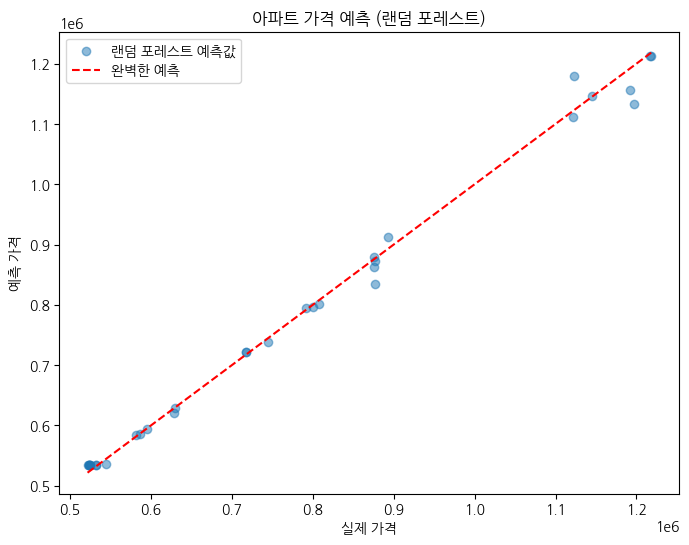

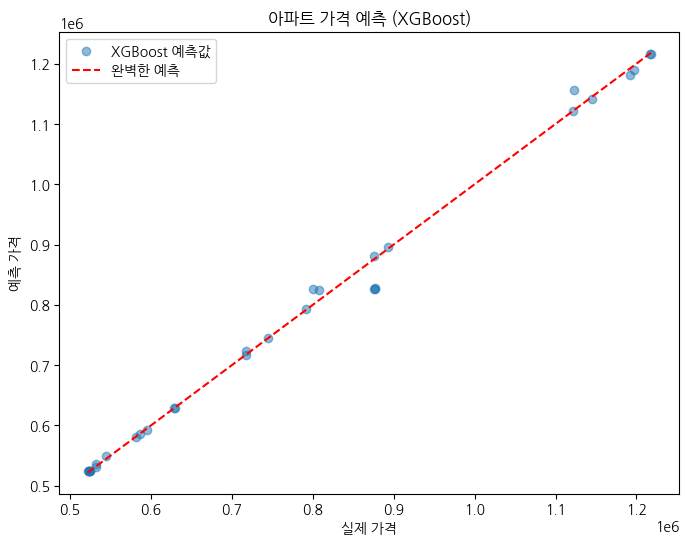

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import koreanize_matplotlib

# 1. 데이터 불러오기 (예시: CSV 파일)
df = pd.read_csv('../PROJECT8/서울_양천구_통합_파일_.csv')  # 파일 이름은 실제 데이터에 맞게 수정하세요.

# 2. 데이터 확인
print(df.head())
print(df.info())

# 3. 결측치 처리 (단순 삭제)
df = df.dropna()

# 3. 아파트분양물량 범주화 (5개의 범주로 나누기)
# df['아파트분양물량_범주'] = pd.cut(df['아파트분양물량'], bins=5, labels=['낮음', '보통', '조금 높음', '높음', '매우 높음'])

# 4. 독립 변수(X)와 종속 변수(y) 설정
features = ['전세가율', '아파트거래현황', '지가지수']  # 독립 변수(피처)
target = '아파트평균매매가격'  # 종속 변수(타겟)

X = df[features]
y = df[target]

# 4. 독립 변수(X)와 종속 변수(y) 설정 (원-핫 인코딩 추가)
# X = pd.get_dummies(df[features], drop_first=True)  # 범주형 변수는 원-핫 인코딩

# 5. 훈련/테스트 데이터 분할 (80:20 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. 데이터 정규화 (필요한 경우)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. 모델 학습 - 랜덤 포레스트
rf_model = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# 8. 모델 학습 - XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# 9. 예측 수행
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_xgb = xgb_model.predict(X_test_scaled)

# 10. 성능 평가 (MAE, RMSE, R²)
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f'[{model_name} 성능]')
    print(f'MAE: {mae:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'R² Score: {r2:.4f}\n')

evaluate_model(y_test, y_pred_rf, '랜덤 포레스트')
evaluate_model(y_test, y_pred_xgb, 'XGBoost')

# 11. 실제값 vs 예측값 시각화 (랜덤 포레스트)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, label='랜덤 포레스트 예측값')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='완벽한 예측')
plt.xlabel('실제 가격')
plt.ylabel('예측 가격')
plt.legend()
plt.title('아파트 가격 예측 (랜덤 포레스트)')
plt.show()

# 11. 실제값 vs 예측값 시각화
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, label='XGBoost 예측값')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='완벽한 예측')
plt.xlabel('실제 가격')
plt.ylabel('예측 가격')
plt.legend()
plt.title('아파트 가격 예측 (XGBoost)')
plt.show()

In [149]:
from sklearn.model_selection import cross_val_score

# 1. 랜덤 포레스트 모델 교차검증
rf_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f'랜덤 포레스트 모델 교차 검증 MAE: {rf_scores.mean():.2f} ± {rf_scores.std():.2f}')

# 2. XGBoost 모델 교차검증
xgb_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f'XGBoost 모델 교차 검증 MAE: {xgb_scores.mean():.2f} ± {xgb_scores.std():.2f}')

랜덤 포레스트 모델 교차 검증 MAE: -8920.78 ± 1069.05
XGBoost 모델 교차 검증 MAE: -7349.38 ± 1390.24


In [150]:
from sklearn.model_selection import GridSearchCV

# 1. 랜덤 포레스트 하이퍼파라미터 튜닝
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='neg_mean_absolute_error')
rf_grid_search.fit(X_train_scaled, y_train)
print(f'랜덤 포레스트 최적 파라미터: {rf_grid_search.best_params_}')
print(f'랜덤 포레스트 튜닝된 모델 교차 검증 MAE: {-rf_grid_search.best_score_:.2f}')

# 2. XGBoost 하이퍼파라미터 튜닝
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6, 10],
    'subsample': [0.8, 1.0]
}

xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='neg_mean_absolute_error')
xgb_grid_search.fit(X_train_scaled, y_train)
print(f'XGBoost 최적 파라미터: {xgb_grid_search.best_params_}')
print(f'XGBoost 튜닝된 모델 교차 검증 MAE: {-xgb_grid_search.best_score_:.2f}')

랜덤 포레스트 최적 파라미터: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
랜덤 포레스트 튜닝된 모델 교차 검증 MAE: 6865.63
XGBoost 최적 파라미터: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}
XGBoost 튜닝된 모델 교차 검증 MAE: 7346.18


In [151]:
# 랜덤 포레스트 모델 최종 성능 평가 (테스트 데이터)
rf_model_best = rf_grid_search.best_estimator_  # 튜닝된 모델로 최종 성능 평가
rf_model_best.fit(X_train_scaled, y_train)
rf_test_mae = mean_absolute_error(y_test, rf_model_best.predict(X_test_scaled))
print(f'랜덤 포레스트 모델 테스트 MAE: {rf_test_mae:.2f}')

랜덤 포레스트 모델 테스트 MAE: 9435.95


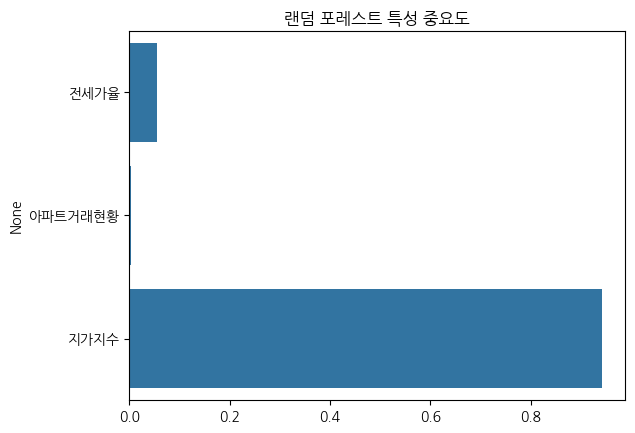

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

# 랜덤 포레스트 모델 특성 중요도 시각화
feature_importances = rf_model_best.feature_importances_
features = X_train.columns
sns.barplot(x=feature_importances, y=features)
plt.title('랜덤 포레스트 특성 중요도')
plt.show()

In [153]:
from sklearn.ensemble import VotingRegressor

# 랜덤 포레스트와 XGBoost 모델 앙상블
ensemble_model = VotingRegressor(estimators=[('rf', rf_model_best), ('xgb', xgb_grid_search.best_estimator_)])
ensemble_model.fit(X_train_scaled, y_train)
ensemble_test_mae = mean_absolute_error(y_test, ensemble_model.predict(X_test_scaled))
print(f'앙상블 모델 테스트 MAE: {ensemble_test_mae:.2f}')

앙상블 모델 테스트 MAE: 8757.16


[XGBoost 튜닝된 모델 성능]
MAE: 9019.61
RMSE: 17340.04
R² Score: 0.9949

[랜덤 포레스트 튜닝된 모델 성능]
MAE: 9435.95
RMSE: 17795.15
R² Score: 0.9946



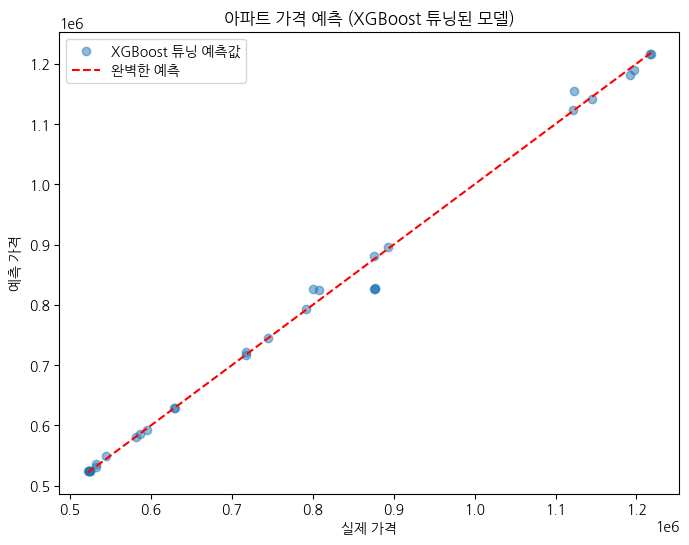

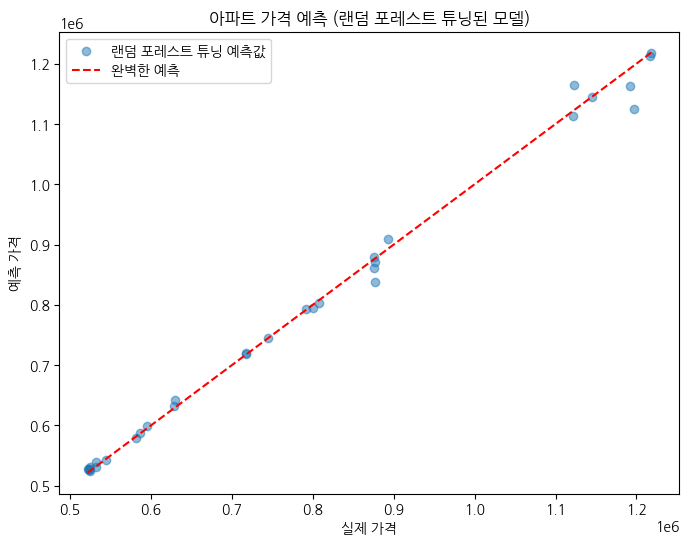

In [154]:
# XGBoost 튜닝된 모델 성능 평가
y_pred_xgb_best = xgb_grid_search.best_estimator_.predict(X_test_scaled)
evaluate_model(y_test, y_pred_xgb_best, 'XGBoost 튜닝된 모델')

# 랜덤 포레스트 튜닝된 모델 성능 평가
y_pred_rf_best = rf_model_best.predict(X_test_scaled)
evaluate_model(y_test, y_pred_rf_best, '랜덤 포레스트 튜닝된 모델')

# 튜닝된 모델(XGBoost 최적 모델)을 사용하여 예측 수행
y_pred_xgb_best = xgb_grid_search.best_estimator_.predict(X_test_scaled)

# 실제값 vs 예측값 시각화 (XGBoost 튜닝된 모델)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb_best, alpha=0.5, label='XGBoost 튜닝 예측값')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='완벽한 예측')
plt.xlabel('실제 가격')
plt.ylabel('예측 가격')
plt.legend()
plt.title('아파트 가격 예측 (XGBoost 튜닝된 모델)')
plt.show()

# 랜덤 포레스트 모델 최종 성능 평가 후 시각화 (MAE)
y_pred_rf_best = rf_model_best.predict(X_test_scaled)

# 실제값 vs 예측값 시각화 (랜덤 포레스트 튜닝된 모델)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf_best, alpha=0.5, label='랜덤 포레스트 튜닝 예측값')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='완벽한 예측')
plt.xlabel('실제 가격')
plt.ylabel('예측 가격')
plt.legend()
plt.title('아파트 가격 예측 (랜덤 포레스트 튜닝된 모델)')
plt.show()

[ 다른 지역 ]

[ 영등포구 ]

In [155]:
# 새로운 데이터 불러오기 (예: 영등포구 데이터)
new_df = pd.read_csv('../PROJECT8/서울_영등포구_통합_파일_.csv')

# 기존 전처리 과정 적용
new_df = new_df.dropna()
# new_df['아파트분양물량_범주'] = pd.cut(new_df['아파트분양물량'], bins=5, labels=['낮음', '보통', '조금 높음', '높음', '매우 높음'])

# 원-핫 인코딩 적용
# X_new = pd.get_dummies(new_df[features], drop_first=True)

X_new = new_df[features]
# y_new = new_df[target]

# 기존 스케일러로 변환
X_new_scaled = scaler.transform(X_new)

# 예측 수행
y_pred_new = rf_model_best.predict(X_new_scaled)

# 예측 결과 확인
new_df['예측된_아파트_가격'] = y_pred_new
print(new_df[['아파트평균매매가격', '예측된_아파트_가격']])

     아파트평균매매가격    예측된_아파트_가격
0       541840  5.341198e+05
1       541255  5.314556e+05
2       537500  5.312957e+05
3       535787  5.314602e+05
4       534660  5.312592e+05
..         ...           ...
151    1124144  1.175230e+06
152    1133212  1.182145e+06
153    1139772  1.183950e+06
154    1143900  1.184513e+06
155    1145848  1.197529e+06

[156 rows x 2 columns]


In [156]:
# # 기존 데이터와 새로운 데이터 합치기
# X_combined = pd.concat([X_train, X_new], axis=0)
# y_combined = pd.concat([y_train, new_df['아파트평균매매가격']], axis=0)

# # 모델 재학습
# rf_model_best.fit(X_combined, y_combined)

# # 새로운 데이터로 예측 수행
# y_pred_new = rf_model_best.predict(X_new_scaled)

# # 성능 평가
# evaluate_model(new_df[target], y_pred_new, '랜덤 포레스트 (새로운 데이터 포함)')

[ 노원구 ]

In [157]:
# 새로운 데이터 불러오기 (예: 노원구 데이터)
new_df = pd.read_csv('../PROJECT8/서울_노원구_통합_파일_.csv')

# 기존 전처리 과정 적용
new_df = new_df.dropna()
# new_df['아파트분양물량_범주'] = pd.cut(new_df['아파트분양물량'], bins=5, labels=['낮음', '보통', '조금 높음', '높음', '매우 높음'])

# 원-핫 인코딩 적용
# X_new = pd.get_dummies(new_df[features], drop_first=True)

X_new = new_df[features]
# y_new = new_df[target]

# 기존 스케일러로 변환
X_new_scaled = scaler.transform(X_new)

# 예측 수행
y_pred_new = rf_model_best.predict(X_new_scaled)

# 예측 결과 확인
new_df['예측된_아파트_가격'] = y_pred_new
print(new_df[['아파트평균매매가격', '예측된_아파트_가격']])

     아파트평균매매가격    예측된_아파트_가격
0       287444  5.357053e+05
1       287106  5.349100e+05
2       285711  5.351285e+05
3       283338  5.351902e+05
4       280944  5.352239e+05
..         ...           ...
151     623304  1.164348e+06
152     627608  1.163825e+06
153     629516  1.167634e+06
154     630780  1.169313e+06
155     631013  1.184830e+06

[156 rows x 2 columns]


[ 강서구 ]

In [158]:
# 새로운 데이터 불러오기 (예: 강서구구 데이터)
new_df = pd.read_csv('../PROJECT8/서울_강서구_통합_파일_.csv')

# 기존 전처리 과정 적용
new_df = new_df.dropna()
# new_df['아파트분양물량_범주'] = pd.cut(new_df['아파트분양물량'], bins=5, labels=['낮음', '보통', '조금 높음', '높음', '매우 높음'])

# 원-핫 인코딩 적용
# X_new = pd.get_dummies(new_df[features], drop_first=True)

X_new = new_df[features]
# y_new = new_df[target]

# 기존 스케일러로 변환
X_new_scaled = scaler.transform(X_new)

# 예측 수행
y_pred_new = rf_model_best.predict(X_new_scaled)

# 예측 결과 확인
new_df['예측된_아파트_가격'] = y_pred_new
print(new_df[['아파트평균매매가격', '예측된_아파트_가격']])

     아파트평균매매가격    예측된_아파트_가격
0       397588  5.340073e+05
1       397343  5.314602e+05
2       395461  5.309987e+05
3       392147  5.309621e+05
4       385578  5.271739e+05
..         ...           ...
151     786712  1.037122e+06
152     791672  1.046867e+06
153     794020  1.056141e+06
154     795467  1.056281e+06
155     796624  1.056664e+06

[156 rows x 2 columns]


[ 부산 남구 ]

In [159]:
# 새로운 데이터 불러오기 (예: 부산 남구 데이터)
new_df = pd.read_csv('../PROJECT8/부산_남구_통합_파일_.csv')

# 기존 전처리 과정 적용
new_df = new_df.dropna()
# new_df['아파트분양물량_범주'] = pd.cut(new_df['아파트분양물량'], bins=5, labels=['낮음', '보통', '조금 높음', '높음', '매우 높음'])

# 원-핫 인코딩 적용
# X_new = pd.get_dummies(new_df[features], drop_first=True)

X_new = new_df[features]
# y_new = new_df[target]

# 기존 스케일러로 변환
X_new_scaled = scaler.transform(X_new)

# 예측 수행
y_pred_new = rf_model_best.predict(X_new_scaled)

# 예측 결과 확인
new_df['예측된_아파트_가격'] = y_pred_new
print(new_df[['아파트평균매매가격', '예측된_아파트_가격']])

     아파트평균매매가격    예측된_아파트_가격
0       248023  5.601249e+05
1       248239  5.601249e+05
2       248477  5.600942e+05
3       248364  5.601249e+05
4       248364  5.600860e+05
..         ...           ...
151     433149  1.033162e+06
152     432499  1.033865e+06
153     430918  1.033569e+06
154     430851  1.033865e+06
155     429785  1.038980e+06

[156 rows x 2 columns]


[ 대전 유성구 ]

In [160]:
# 새로운 데이터 불러오기 (예: 대전 유성구성구 데이터)
new_df = pd.read_csv('../PROJECT8/대전_유성구_통합_파일_.csv')

# 기존 전처리 과정 적용
new_df = new_df.dropna()
# new_df['아파트분양물량_범주'] = pd.cut(new_df['아파트분양물량'], bins=5, labels=['낮음', '보통', '조금 높음', '높음', '매우 높음'])

# 원-핫 인코딩 적용
# X_new = pd.get_dummies(new_df[features], drop_first=True)

X_new = new_df[features]
# y_new = new_df[target]

# 기존 스케일러로 변환
X_new_scaled = scaler.transform(X_new)

# 예측 수행
y_pred_new = rf_model_best.predict(X_new_scaled)

# 예측 결과 확인
new_df['예측된_아파트_가격'] = y_pred_new
print(new_df[['아파트평균매매가격', '예측된_아파트_가격']])

     아파트평균매매가격    예측된_아파트_가격
0       257542  5.565628e+05
1       251802  5.364186e+05
2       250823  5.322864e+05
3       250302  5.316078e+05
4       249844  5.316078e+05
..         ...           ...
151     440658  1.033162e+06
152     440480  1.033176e+06
153     440369  1.033176e+06
154     440733  1.033439e+06
155     440605  1.034169e+06

[156 rows x 2 columns]


[ 대구 달서구 ]

In [161]:
# 새로운 데이터 불러오기 (예: 대구 달서구 데이터)
new_df = pd.read_csv('../PROJECT8/대구_달서구_통합_파일_.csv')

# 기존 전처리 과정 적용
new_df = new_df.dropna()
# new_df['아파트분양물량_범주'] = pd.cut(new_df['아파트분양물량'], bins=5, labels=['낮음', '보통', '조금 높음', '높음', '매우 높음'])

# 원-핫 인코딩 적용
# X_new = pd.get_dummies(new_df[features], drop_first=True)

X_new = new_df[features]
# y_new = new_df[target]

# 기존 스케일러로 변환
X_new_scaled = scaler.transform(X_new)

# 예측 수행
y_pred_new = rf_model_best.predict(X_new_scaled)

# 예측 결과 확인
new_df['예측된_아파트_가격'] = y_pred_new
print(new_df[['아파트평균매매가격', '예측된_아파트_가격']])

     아파트평균매매가격    예측된_아파트_가격
0       170206  5.601010e+05
1       171051  5.626570e+05
2       172081  5.626570e+05
3       173765  5.626570e+05
4       174309  5.626570e+05
..         ...           ...
151     298051  1.033162e+06
152     297407  1.033162e+06
153     296498  1.033162e+06
154     295213  1.033569e+06
155     293606  1.033115e+06

[156 rows x 2 columns]


[ 광주 남구 ]

In [162]:
# 새로운 데이터 불러오기 (예: 광주 남구구 데이터)
new_df = pd.read_csv('../PROJECT8/광주_남구_통합_파일_.csv')

# 기존 전처리 과정 적용
new_df = new_df.dropna()

X_new = new_df[features]
# y_new = new_df[target]

# 기존 스케일러로 변환
X_new_scaled = scaler.transform(X_new)

# 예측 수행
y_pred_new = rf_model_best.predict(X_new_scaled)

# 예측 결과 확인
new_df['예측된_아파트_가격'] = y_pred_new
print(new_df[['아파트평균매매가격', '예측된_아파트_가격']])

     아파트평균매매가격    예측된_아파트_가격
0       139487  5.606097e+05
1       139487  5.600942e+05
2       140023  5.601249e+05
3       140308  5.598099e+05
4       141308  5.598581e+05
..         ...           ...
151     323336  1.051021e+06
152     323471  1.041734e+06
153     322900  1.038980e+06
154     322724  1.040707e+06
155     322271  1.051989e+06

[156 rows x 2 columns]


[ 데이터 추가 학습 ]

In [163]:
# 기존 데이터와 새로운 데이터 합치기
X_combined = pd.concat([X_train, X_new], axis=0)
y_combined = pd.concat([y_train, new_df[target]], axis=0)

# 모델 재학습
rf_model_best.fit(X_combined, y_combined)

# 새로운 데이터로 예측 수행
y_pred_new = rf_model_best.predict(X_new_scaled)

# 성능 평가
evaluate_model(new_df[target], y_pred_new, '랜덤 포레스트 (새로운 데이터 포함)')

[랜덤 포레스트 (새로운 데이터 포함) 성능]
MAE: 331418.71
RMSE: 341697.32
R² Score: -15.8756



c:\Users\KDP-31-\anaconda3\envs\ML_PY39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
